# Volume 3: Speech Recognition using CDHMMs
    Daniel Perkins
    MATH 405
    1/21/25

In [1]:
import os
import MFCC
import re
import random

import numpy as np
from hmmlearn import hmm
from scipy.io import wavfile
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal

## Problem 1

Write a function `sample_gmmhmm` which accepts an integer $T$, and draws $T$ samples from the GMMHMM given in the lab pdf.

Use your function to draw $T=900$ samples from the GMMHMM.
Use `sklearn.decomposition.PCA` with 2 components to plot the observations in two-dimensional space. 
Color the observations by state.
How many distinct clusters do you see?

Hint: the function `np.random.choice` will be useful for drawing the hidden states and the GMM components, and `np.random.multivariate_normal` for the observation sequence. 
When plotting the samples, using the keyword argument `c` in `plt.scatter` allows you to specify the colors of the individual points.

In [55]:
def sample_gmmhmm(T):
    """
    Simulate from the GMMHMM given in the problem, returning T samples.
    
    Returns
    -------
    states : ndarray of shape (n_sim,)
        The sequence of states
    obs : ndarray of shape (n_sim, M)
        The generated observations (vectors of length M)
    """
    N = 3
    K = 5
    M = 4
    
    ## Define the GMMHMM parameters
    # NxN transition matrix 
    A = np.array([[.3, .3, .4], [.2, .3, .5], [.3, .2, .5]])
    # NxK collection of component weights
    weights = np.array([[.3, .2, .1, .2, .2], [.1, .3, .3, .2, .1], 
                        [.1, .3, .2, .1, .3]])
    # NxKxM collection of component means
    means = np.array([np.floor(np.random.uniform(-100, 100, size=(5, 4))) 
                            for i in range(3)])
    # NxKx(MxM) collection of component covariance matrices       
    covars = np.array([[np.floor(np.random.uniform(1, 20))*np.eye(4) 
                            for i in range(5)] for j in range(3)])
    # (N,) ndarray initial state distribution 
    pi = np.array([.15, .15, .7])
    

    # Variables to store things
    states = np.empty(T)
    obs = np.empty((T, M))

    # Initial draw  
    X = np.random.choice(N, p=pi)  # Determine the hidden state
    states[0] = X
    Y = np.random.choice(K, p=weights[X])   # Determine GMM component Y
    Z = multivariate_normal.rvs(mean=means[X, Y], cov=covars[X, Y])  # Sample Z from normal
    obs[0] = Z
    
    # Do it for the rest of t
    for t in range(1, T):
        X = np.random.choice(N, p=A[X])  # Choose the next random state
        states[t] = X
        Y = np.random.choice(K, p=weights[X])   # Determine GMM component Y
        Z = multivariate_normal.rvs(mean=means[X, Y], cov=covars[X, Y])  # Sample Z from normal
        obs[t] = Z
        
    return states, obs

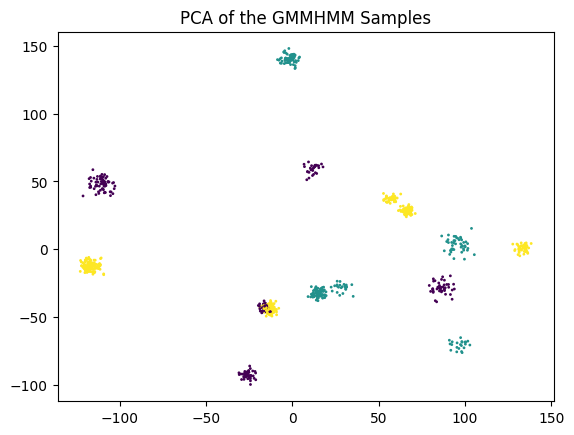

In [78]:
states, obs = sample_gmmhmm(T=900)

# Reduce to 2 dimensions using PCA
pca = PCA(n_components=2)
obs_reduced = pca.fit_transform(obs)

X, Y = obs_reduced.T

plt.title("PCA of the GMMHMM Samples")
plt.scatter(X, Y, c=states, cmap='viridis', s=1)
plt.show()

There appears to be 14 different clusters. ALl but one of them contain points of just one class.

## Problem 2

In the remainder of this lab, we will create a speech recognition system for the vocabulary of the following five words/phrases: "biology", "mathematics", "political science", "psychology", and "statistics".

The `Samples` folder contains 30 recordings for each of the words/phrases in the vocabulary.
These audio samples are 2 seconds in duration, recorded at a rate of 44100 samples per second, with samples stored as 16-bit signed integers in WAV format. 
For each of the words, create a list holding the MFCC coefficients of the recordings of that word.

The function `scipy.io.wavfile.read` can be used to load the sound files, and the function `extract` in `MFCC.py` implements the MFCC coefficient algorithm.

In [2]:
files = os.listdir("Samples") # Get the file paths

# Store the data in a dictionary
data = {"Biology": [], "Mathematics": [], "PoliticalScience": [], "Psychology": [], "Statistics": []}

# Load in each file and store the coefficients
for file in files:
    samplerate, sound_data = wavfile.read("Samples/" + file)
    coefficients = MFCC.extract(sound_data)
    
    # Store the coeeficient to the corresponding word
    if "Biology" in file: data["Biology"].append(coefficients)
    elif "Mathematics" in file: data["Mathematics"].append(coefficients)
    elif "PoliticalScience" in file: data["PoliticalScience"].append(coefficients)
    elif "Psychology" in file: data["Psychology"].append(coefficients)
    elif "Statistics" in file: data["Statistics"].append(coefficients)
    else: print("File not valid")  # Print error message if the file doesn't have the correct name

/tmp/ipykernel_114902/2556881897.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, sound_data = wavfile.read("Samples/" + file)


## Problem 3

For each word, randomly split the list of MFCCs into a training set of 20 samples and a test set of the remaining 10 samples.

Use the training sets to train GMMHMMs on each word in the vocabulary.
For each word in the vocabulary, train 10 GMMHMMs on the training set, using `n_components=5`.
Keep the model with the highest log-likelihood for each word.

In [3]:
# Extract each dataset
biology_data = data["Biology"]
math_data = data["Mathematics"]
polysci_data = data["PoliticalScience"]
psychology_data = data["Psychology"]
stats_data = data["Statistics"]
words = ["Biology", "Mathematics", "PoliticalScience", "Psychology", "Statistics"]

# Randomly shuffle the data
random.shuffle(biology_data)
random.shuffle(math_data)
random.shuffle(polysci_data)
random.shuffle(psychology_data)
random.shuffle(stats_data)

# Split into training and test sets
train_biology_data, test_biology_data = biology_data[:20], biology_data[20:]
train_math_data, test_math_data = math_data[:20], math_data[20:]
train_polysci_data, test_polysci_data = polysci_data[:20], polysci_data[20:]
train_psychology_data, test_psychology_data = psychology_data[:20], psychology_data[20:]
train_stats_data, test_stats_data = stats_data[:20], stats_data[20:]
train_data = [train_biology_data, train_math_data, train_polysci_data, train_psychology_data, train_stats_data]
test_data = [test_biology_data, test_math_data, test_polysci_data, test_psychology_data, test_stats_data]

#Train a GMMHMM on each training set
models = [None]*len(train_data)  # To store the best model for each word
for i, datum in enumerate(train_data):
    best_log_likelihood = -np.inf
    
    data_collected = np.vstack(datum)   # hmmlearn expects the data to be in a single array:
    lengths = [item.shape[0] for item in datum] # To separate the sequences, it requires the length of each
    
    for iteration in range(10):  # Train 10 for each model
        # Initialize and train the model
        model = hmm.GMMHMM(n_components=5, covariance_type="diag")
        model.fit(data_collected, lengths=lengths)
        
        # Check the log-likelihood
        log_likelihood = model.monitor_.history[-1]
        print(f"{words[i]}: Iteration #{iteration+1} --> Log_likelihood: {log_likelihood}")
        
        # If the log-likelihhod is maximized, store the model
        if log_likelihood > best_log_likelihood:
            best_log_likelihood = log_likelihood
            models[i] = model
    print()



Biology: Iteration #1 --> Log_likelihood: -35570.56773590295
Biology: Iteration #2 --> Log_likelihood: -35388.95800489321
Biology: Iteration #3 --> Log_likelihood: -35411.6496447697
Biology: Iteration #4 --> Log_likelihood: -35427.45825611221
Biology: Iteration #5 --> Log_likelihood: -35448.29217346505
Biology: Iteration #6 --> Log_likelihood: -35392.193647976026
Biology: Iteration #7 --> Log_likelihood: -36673.60970645326
Biology: Iteration #8 --> Log_likelihood: -35143.92520964612
Biology: Iteration #9 --> Log_likelihood: -35391.253305667
Biology: Iteration #10 --> Log_likelihood: -35422.10858493266

Mathematics: Iteration #1 --> Log_likelihood: -36433.16369248652
Mathematics: Iteration #2 --> Log_likelihood: -36886.95580187594
Mathematics: Iteration #3 --> Log_likelihood: -37668.687361963275
Mathematics: Iteration #4 --> Log_likelihood: -38883.76512167208
Mathematics: Iteration #5 --> Log_likelihood: -36425.95419950551
Mathematics: Iteration #6 --> Log_likelihood: -36880.89609971349

## Problem 4

Write a `predict` function for your speech recognition model.
In this function:
 - Accept the MFCC coefficients of the speech sample to be predicted.
 - Find the log probability density of the coefficients for each word's GMMHMM.
 - Return the word with the highest probability as the speech recognition model's prediction.

In [8]:
def predict(z):
    # Initialize things
    best_log_likelihood = -np.inf
    prediction = None

    for i, model in enumerate(models):  # Try each model
        
        log_likelihood = model.score(z)  # Calculate the log likelihood
        
        if log_likelihood > best_log_likelihood:  # If it is the best so far, update the prediction
            best_log_likelihood = log_likelihood
            prediction = words[i]
            
    return prediction
            
# Example for first word in the biology test set
print(predict(test_biology_data[0]))
        

Biology


## Problem 5

For each of the five test sets, call your `predict` function on each sample, and find the proportion of each test set that your model predicts correctly.
Display your results.
How well does your model perform on this dataset?

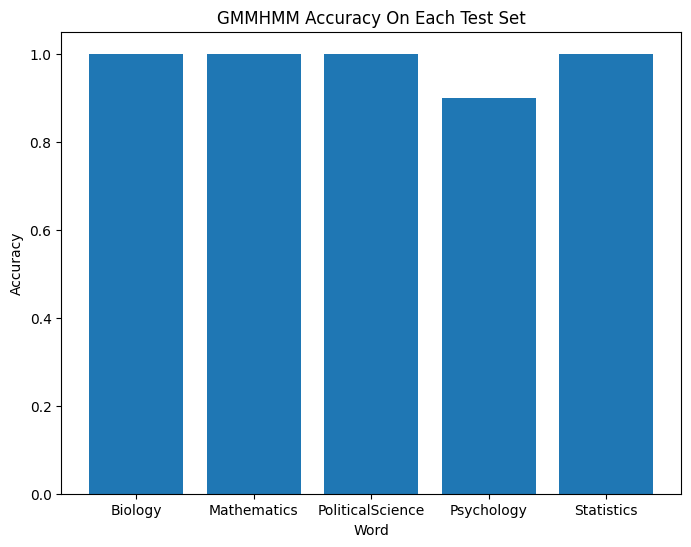

In [14]:
accuracies = []

for i, datum in enumerate(test_data):
    
    # To keep track of accuracy
    num_correct = 0
    total_num = 0
    
    # Make prediction for each sample in the dataset
    for z in datum:  
        prediction = predict(z)
        if prediction == words[i]: num_correct += 1
        total_num += 1
    
    # Store the accuracy
    accuracies.append(num_correct / total_num)
    
# Create a bar chart to display the results
plt.figure(figsize=(8, 6))  # Increase width to give more space
plt.bar(words, accuracies)
plt.xlabel('Word')
plt.ylabel('Accuracy')
plt.title('GMMHMM Accuracy On Each Test Set')
plt.show()
        

The model seemed to do very well. It only had one incorrect prediction. This is probably because each word is very different. So, it was a relatively easy task.